In [1]:
from common import colors, pvalue_thresholds, sbarlw, savefig

In [2]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

/home/eharkin/projects/5HTGIF-dev


In [3]:
import warnings
import re
import copy
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.interpolate import griddata
from tqdm.notebook import tqdm, trange

from ezephys import pltools
from statannot import add_stat_annotation

from grr.Simulation import GIFnet_Simulation
from grr.GainEstimator import GainEstimator
from grr.Tools import raiseExpectedGot, timeToIndex, reprint
from grr.Spiketrain import PSTH
from grr.CurveFit import plot_linear_fit

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'GIF_network')

In [5]:
DATA_PATH = os.path.join('data', 'simulations', 'GIF_network', 'deriv_input')

sim_dict = {'Baseline level': [], 'Rep': [], 'Model': []}

for baseline_level in ['-0.080', '-0.060', '-0.040', '-0.020', '0.000', '0.020', '0.040', '0.060', '0.080']:
    for fname in os.listdir(os.path.join(DATA_PATH, '{}_baseline'.format(baseline_level))):
        if fname.endswith(('hdf5', 'h5')):

            try:
                sim_dict['Model'].append(
                    GIFnet_Simulation(
                        os.path.join(DATA_PATH, '{}_baseline'.format(baseline_level), fname), 
                        mode = 'r'
                    )
                )
                sim_dict['Baseline level'].append(float(baseline_level))
                sim_dict['Rep'].append(
                    int(re.search(r'rep([0-9]+)', fname).groups()[-1])
                )
            except IOError:
                print('Problem with {} baseline {}'.format(baseline_level, fname))
                continue
            

sim_df = pd.DataFrame(sim_dict).sort_values(['Rep'])
sim_df.reset_index(inplace=True, drop=True)
sim_df.head()

,Baseline level,Model,Rep
0,-0.08,"[connectivity_matrix, gaba, ser]",0
1,-0.06,"[connectivity_matrix, gaba, ser]",0
2,0.02,"[connectivity_matrix, gaba, ser]",0
3,0.04,"[connectivity_matrix, gaba, ser]",0
4,0.06,"[connectivity_matrix, gaba, ser]",0


In [6]:
sim_df['Principal PSTH'] = None
sim_df['Principal PSTH'] = sim_df['Principal PSTH'].astype(object)
sim_df['GABA PSTH'] = None
sim_df['GABA PSTH'] = sim_df['GABA PSTH'].astype(object)

In [7]:
sim_df = sim_df.loc[(sim_df['Baseline level'] == 0.04) & (sim_df['Rep'] == 0), :]
sim_df.reset_index(inplace=True)

In [8]:
PSTH_width = 50.

for i in trange(sim_df.shape[0], desc='Model'):
    
    # Get PSTH from 5HT population.
    sim_df.at[i, 'Principal PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in trange(sim_df.loc[i, 'Model'].get_no_sweeps(), desc='5HT sweep', leave=False):
        sim_df.loc[i, 'Principal PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].ser_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_ser_neurons()
        )
    
    # Get PSTHs from GABA population.
    sim_df.at[i, 'GABA PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in trange(sim_df.loc[i, 'Model'].get_no_sweeps(), desc='GABA sweep', leave=False):
        sim_df.loc[i, 'GABA PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].gaba_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_gaba_neurons()
        )

print('\nDone!')

SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnTW9kZWwnLCBtYXg9MS4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3dpZHRoPXXigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=




Done!


In [9]:
sim_df.head()

,index,Baseline level,Model,Rep,Principal PSTH,GABA PSTH
0,3,0.04,"[connectivity_matrix, gaba, ser]",0,"[[1.7000001668930054, 1.7000001668930054, 1.73...","[[7.300006866455078, 7.300006866455078, 7.3500..."


In [10]:
BASELINE_LEVELS = np.array([-0.080, -0.060, -0.040, -0.020, 0, 0.020, 0.040, 0.060, 0.080])
deriv_in_pA_s = 100 / (np.logspace(np.log10(100), np.log10(1e4), 20) * 1e-3)
sample_trace_model, sample_trace_ser_psth, sample_trace_som_psth = sim_df.loc[
    (sim_df['Baseline level'] == BASELINE_LEVELS[6]) & (sim_df['Rep'] == 0), ['Model', 'Principal PSTH', 'GABA PSTH']
].iloc[0, :]

In [11]:
with open(os.path.join(DATA_PATH, '0.040_baseline', 'input.dat'), 'rb') as f:
    input_arr = pickle.load(f)
    f.close()

In [12]:
SWEEPS_TO_SHOW = [10, 5, 0]
TIME_SLICE = slice(19000, 35000)
TIME_VEC = np.arange(0, TIME_SLICE.stop - TIME_SLICE.start) * input_arr['metaparams']['dt'] * 1e-3

Saving svg
Saving png
Done!


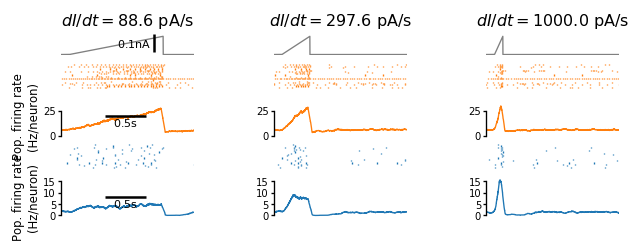

In [14]:
fig = plt.figure(figsize=(6, 2))

spec = gs.GridSpec(1, 3, hspace=0.6, wspace=0.6)

for i, sweep in enumerate(SWEEPS_TO_SHOW):
    ax = plt.subplot(spec[0, i])
    
    trace_spec = gs.GridSpecFromSubplotSpec(5, 3, spec[0, i], height_ratios=[0.5, 0.7, 1, 0.7, 1])
    
    plt.subplot(trace_spec[0, :])
    plt.title('$dI/dt = {:.1f}$ pA/s'.format(1e3 * input_arr['metaparams']['deriv_in_nA_s'][sweep]))
    plt.plot(TIME_VEC, input_arr['ser_input'][sweep, 0, TIME_SLICE].T, color=colors['input'])
    plt.xlim(0, TIME_VEC[-1])
    if i == 0:
        pltools.add_scalebar(
            y_size=0.1,
            y_units='nA',
            omit_x=True,
            round=False,
            anchor=(0.7, 0.1),
            linewidth=sbarlw
        )
    else:
        pltools.hide_border()
        pltools.hide_ticks()
    
    plt.subplot(trace_spec[1, :])
    plt.eventplot(
        [np.where(sample_trace_model.gaba_spktrains[sweep, j, TIME_SLICE])[0] * 0.1 * 1e-3 for j in range(20)],
        color=colors['som']
    )
    plt.xlim(0, TIME_VEC[-1])
    pltools.hide_ticks()
    pltools.hide_border('a')
    
    plt.subplot(trace_spec[2, :])
    plt.plot(TIME_VEC, sample_trace_som_psth[sweep, TIME_SLICE].T, color=colors['som'])
    plt.xlim(0, TIME_VEC[-1])
    plt.ylim(-0.5, 40)
    if i == 0:
        plt.ylabel('Pop. firing rate\n(Hz/neuron)')
        pltools.add_scalebar(
            x_size=0.5, 
            x_units='s', 
            anchor=(0.7, 0.5), 
            round=False, 
            omit_y=True, 
            remove_frame=False,
            linewidth=sbarlw
        )
    pltools.hide_border('trb', trim=True)
    
    plt.subplot(trace_spec[3, :])
    plt.eventplot(
        [np.where(sample_trace_model.ser_spktrains[sweep, j, TIME_SLICE])[0] * 0.1 * 1e-3 for j in range(20)],
        color=colors['ser']
    )
    plt.xlim(0, TIME_VEC[-1])
    pltools.hide_ticks()
    pltools.hide_border('a')
    
    plt.subplot(trace_spec[4, :])
    plt.plot(TIME_VEC, sample_trace_ser_psth[sweep, TIME_SLICE].T, color=colors['ser'])
    plt.xlim(0, TIME_VEC[-1])
    plt.ylim(-0.5, 17)
    plt.yticks([0, 5, 10, 15])
    if i == 0:
        plt.ylabel('Pop. firing rate\n(Hz/neuron)')
        pltools.add_scalebar(
            x_size=0.5, 
            x_units='s', 
            anchor=(0.7, 0.5), 
            round=False, 
            omit_y=True, 
            remove_frame=False,
            linewidth=sbarlw
        )
    pltools.hide_border('trb', trim=True)



plt.tight_layout()

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'derivative_filter'))